In [1]:
import nx
%load_ext autoreload
%autoreload 2

First, we read the actorfilm.csv, which contains actors, their IDs and the films they were in. We also filter out movies, which are after 1990.

In [2]:
import pandas as pd

df_actors = pd.read_csv('../Datasets/IMDB/actorfilms.csv', low_memory=False)
# Filter to keep only films from 1990 or before
df_actors = df_actors[df_actors['Year'] >= 1990]

Here we can see the field's of the df.

In [3]:
df_actors

,Actor,ActorID,Film,Year,Votes,Rating,FilmID
39,Lauren Bacall,nm0000002,Ernest & Celestine,2012,18793,7.9,tt1816518
40,Lauren Bacall,nm0000002,The Forger,2012,4472,5.4,tt1368858
41,Lauren Bacall,nm0000002,All at Sea,2010,110,5.7,tt0858500
42,Lauren Bacall,nm0000002,The Walker,2007,5256,5.8,tt0783608
43,Lauren Bacall,nm0000002,Manderlay,2005,22622,7.3,tt0342735
...,...,...,...,...,...,...,...
191868,Roman Griffin Davis,nm9877392,Jojo Rabbit,2019,310904,7.9,tt2584384
191869,Lexi Rabe,nm9962642,Silk Road,2021,2050,5.9,tt7937254
191870,Lexi Rabe,nm9962642,Avengers: Endgame,2019,849079,8.4,tt4154796
191871,Lexi Rabe,nm9962642,Godzilla: King of the Monsters,2019,146737,6.0,tt3741700


We also read in the title.crew.tsv, which contains movies and the directors directed them. The movies and the directors are represented with the IMDB movieIDs and directorIDs.

In [4]:
df_movie_directors = pd.read_csv('../Datasets/IMDB/title.crew.tsv', sep='\t', low_memory=False)
df_movie_directors

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,nm0721526
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
12048914,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
12048915,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
12048916,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
12048917,tt9916856,nm10538645,nm6951431


We also use the name.basics.tsv which have IMBd IDs of people and their names.

In [5]:
df_name_to_id = pd.read_csv('../Datasets/IMDB/name.basics.tsv', sep='\t', low_memory=False)

We also create two dictionaries. In movie_directors_dict the keys are the movieIDs and the values are the directorIDs.
IN the name_lookup the keys are the directorIDs and the values are their names.

In [6]:
import pandas as pd

# Pre-compute lookups to avoid repeated DataFrame operations
movie_directors_dict = df_movie_directors.set_index('tconst')['directors'].to_dict()
name_lookup = df_name_to_id.set_index('nconst')['primaryName'].to_dict()

Here we make a actor_directors_dict where we map each actor to the list of director they worked with in order.

In [7]:
from Director_Director_Graph.director_graph_functions import build_actor_director_dict

# Create a dictionary mapping each actor to their ordered list of directors
actor_directors_dict = build_actor_director_dict(df_actors, movie_directors_dict, name_lookup)

for actor in list(actor_directors_dict.keys())[:5]:
    directors = actor_directors_dict[actor]
    print(f"\n{actor}: worked with {len(directors)} director(s)")
    for d in directors[:3]:  # Show first 3
        print(f"  - {d['director']} on '{d['film']}' ({d['year']})")
    if len(directors) > 3:
        print(f"  ... and {len(directors) - 3} more")


Lauren Bacall: worked with 23 director(s)
  - Rob Reiner on 'Misery' (1990)
  - Robert Lieberman on 'All I Want for Christmas' (1991)
  - Jim Kaufman on 'A Star for Two' (1991)
  ... and 20 more

Marlon Brando: worked with 8 director(s)
  - Andrew Bergman on 'The Freshman' (1990)
  - John Glen on 'Christopher Columbus: The Discovery' (1992)
  - Jeremy Leven on 'Don Juan DeMarco' (1994)
  ... and 5 more

Kirk Douglas: worked with 5 director(s)
  - John Landis on 'Oscar' (1991)
  - Jonathan Lynn on 'Greedy' (1994)
  - John Asher on 'Diamonds' (1999)
  ... and 2 more

John Gielgud: worked with 13 director(s)
  - James Scott on 'Strike It Rich' (1990)
  - Peter Greenaway on 'Prospero's Books' (1991)
  - John G. Avildsen on 'The Power of One' (1992)
  ... and 10 more

Alec Guinness: worked with 2 director(s)
  - Steven Soderbergh on 'Kafka' (1991)
  - Anthony Waller on 'Mute Witness' (1995)


Here we get all the directors actors worked with.

In [8]:
# Extract all unique directors from actor_directors_dict
all_directors = set()

for actor, directors_list in actor_directors_dict.items():
    # Each item in directors_list is a dict with 'director', 'year', 'film'
    for d in directors_list:
        all_directors.add(d['director'])


We make the director_graph here. We construct a directed weighted graph \[G = (D, E, w)\], where: each director \( d_i \in D \) is a node in the graph.
For two directors \( d_i, d_j \in D \), we create a directed edge v\[(d_i \rightarrow d_j) \in E\], if there exists at least one actor \( a \in A \) who worked with director \( d_i \) before working with director \( d_j \). The weight indicate the number of actors who did this.



In [9]:
from Director_Director_Graph.director_graph_functions import make_director_graph

director_graph = make_director_graph(all_directors, actor_directors_dict )

print(f"This graph has {director_graph.number_of_nodes()} directors.")
print(f"This graph has {director_graph.number_of_edges()} edges.")

# Show top 10 most common transitions
print(f"\nTop 10 most common director transitions:")
edges_sorted = sorted(director_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for i, (from_dir, to_dir, data) in enumerate(edges_sorted[:10], 1):
    print(f"  {i:2d}. {from_dir} → {to_dir} (weight: {data['weight']})")

This graph has 17117 directors.
This graph has 134599 edges.

Top 10 most common director transitions:
   1. Anthony Russo → Joe Russo (weight: 207)
   2. Bobby Farrelly → Peter Farrelly (weight: 149)
   3. Ethan Coen → Joel Coen (weight: 135)
   4. Lana Wachowski → Lilly Wachowski (weight: 92)
   5. Joel Coen → Ethan Coen (weight: 88)
   6. Phil Lord → Christopher Miller (weight: 80)
   7. Ron Clements → John Musker (weight: 61)
   8. Shari Springer Berman → Robert Pulcini (weight: 56)
   9. Jason Friedberg → Aaron Seltzer (weight: 56)
  10. Mark Neveldine → Brian Taylor (weight: 54)


For easier visualization we only take the topn (in this case 100) directors, who have the highest degree. We also remove the edges which has weight lower than 3. We also only plot the nodes which has neighbours.

Filtered graph for visualization:
  Nodes: 78
  Edges: 128


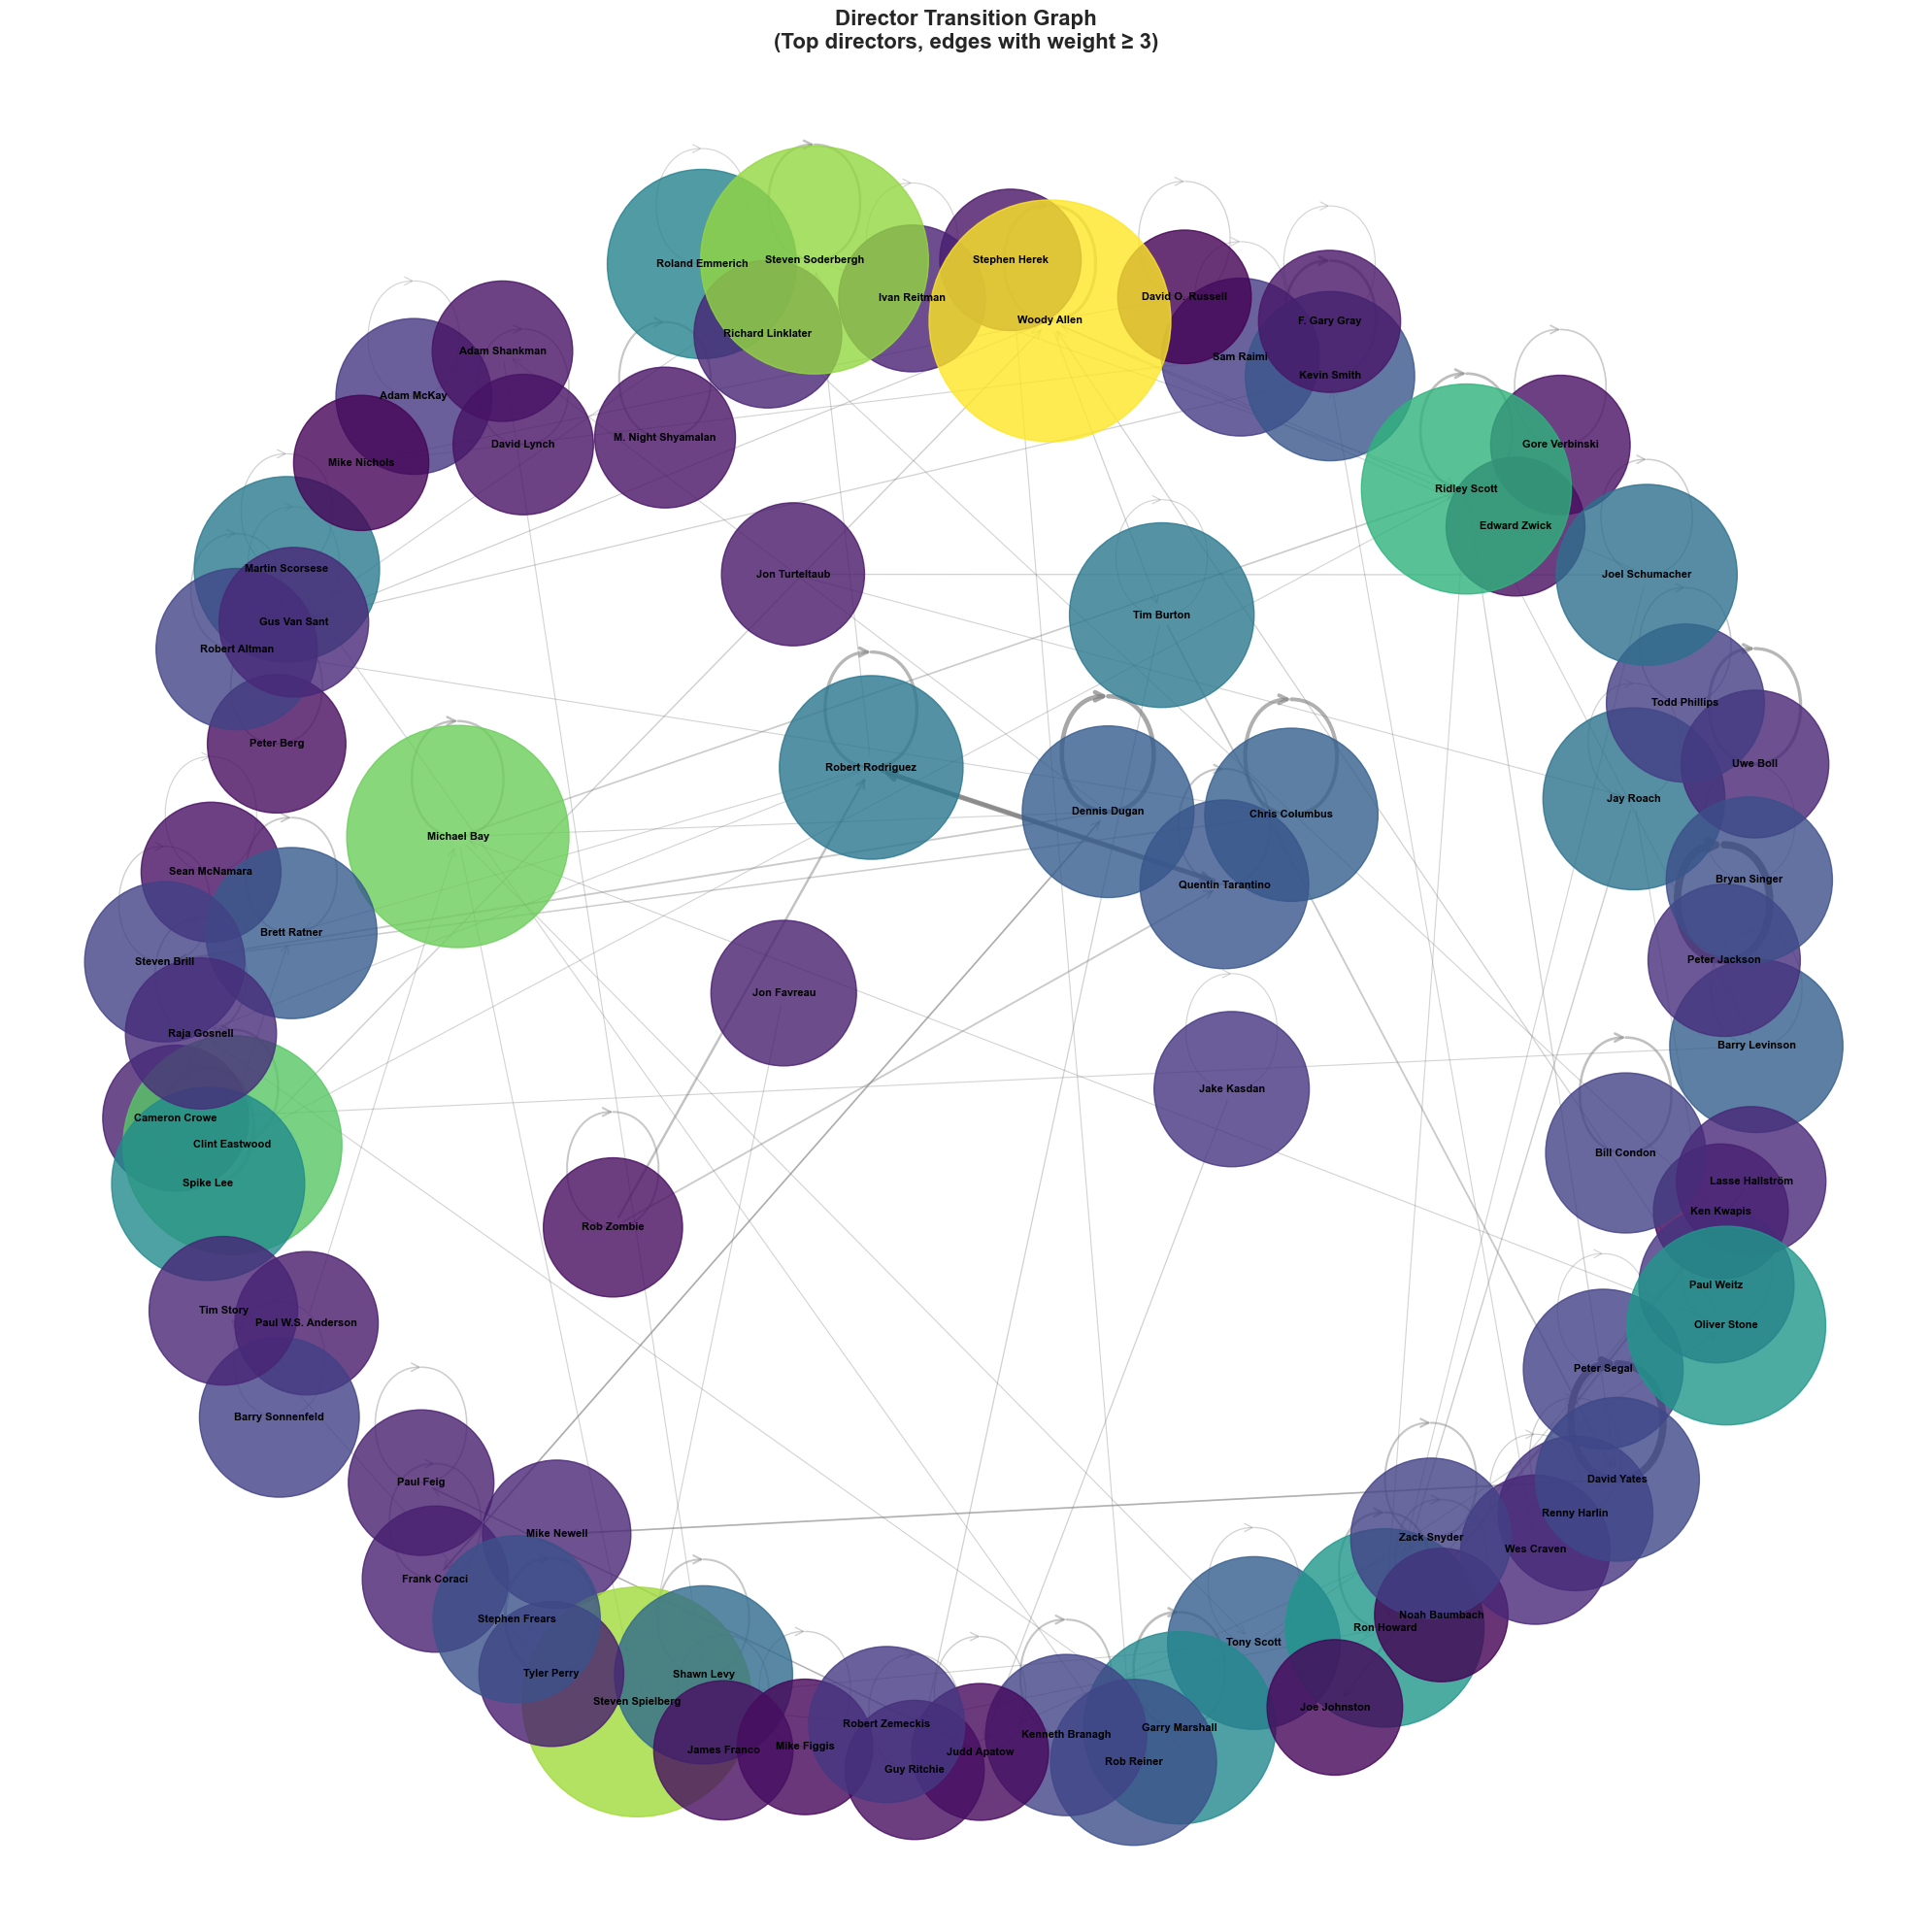


Graph saved as 'director_transition_graph.png'


In [10]:
from Director_Director_Graph.visualizations import visualize_director_director_graph_filtered

visualize_director_director_graph_filtered(director_graph, top_n=100)

In [11]:
import networkx as nx
degree_centrality = nx.degree_centrality(director_graph)
eigen_centrality = nx.eigenvector_centrality(director_graph)

The degrees with high centrality are the popular directors.

In [12]:
sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]

[('Woody Allen', 0.03756718859546623),
 ('Steven Spielberg', 0.033886422061229264),
 ('Steven Soderbergh', 0.03336059827062398),
 ('Michael Bay', 0.03172470203318532),
 ('Clint Eastwood', 0.03078990418322038),
 ('Ridley Scott', 0.028336059827062398),
 ('Oliver Stone', 0.025356391680299135),
 ('Ron Howard', 0.025297966814676328),
 ('Spike Lee', 0.02395419490535172),
 ('Garry Marshall', 0.023778920308483293)]

Here we collect the popular directors. As there are no datasets available with director popularity score, we took the IMDb movies.csv and calculate the popularity by summing the result of multiplying the rating of their movies and the number of rating. We explain the reasons in the report.

In [13]:
from Artist_Director_Graph.actor_director_functions import get_popular_directors


#We use the IMDb dataset and get rid of movies before 1990
df_movies_imdb = pd.read_csv('../Datasets/IMDb movies.csv', index_col=0, low_memory=False)
df_movies_imdb = df_movies_imdb[pd.to_numeric(df_movies_imdb['year'], errors='coerce') >= 1990]

# Sort by average popularity
director_popularity = get_popular_directors(df_movies_imdb)


In [14]:
director_popularity

,director,total_popularity,num_movies
4911,Christopher Nolan,99486881.7,11
21629,Quentin Tarantino,75651625.0,12
25560,Steven Spielberg,64856945.6,20
21042,Peter Jackson,60483109.9,11
6127,David Fincher,56634054.9,10
...,...,...,...
27983,Waleed Bedour,139.2,1
18524,Michele Lunella,138.6,1
12405,Jianrong Zhuo,133.1,1
388,Aeneas Middleton,128.7,1


We make a popularity_threshold at 75th percentile, so we only take the most popular actors. The popular_directors is the set containing these directors' name.

In [15]:
# We find the most popular directors
popularity_threshold = director_popularity['total_popularity'].quantile(0.75)
popular_directors = set(director_popularity[director_popularity['total_popularity'] >= popularity_threshold]['director'])

In [16]:
print(f"We have {len(popular_directors)} number of popular directors.")

We have 7256 number of popular directors.


Analyze how actors transition between working with popular and non-popular directors from the start to the end of their careers. For each actor, we find their first and last directors and classify the transition. The director categories are: popular and non-popular.

In [17]:
from Director_Director_Graph.director_graph_functions import calculate_actor_transitions

transitions = {
    ('Non-Popular', 'Non-Popular'): 0,
    ('Non-Popular', 'Popular'): 0,
    ('Popular', 'Non-Popular'): 0,
    ('Popular', 'Popular'): 0
}
actor_min_films = 3  # Only consider actors with at least 3 films
total_actors=calculate_actor_transitions(actor_directors_dict, popular_directors, transitions, actor_min_films)

Actor Career Transitions (actors with >= 3 films):
Non-Popular     → Non-Popular    :   792 actors (  9.7%)
Non-Popular     → Popular        :   774 actors (  9.5%)
Popular         → Non-Popular    :  1860 actors ( 22.8%)
Popular         → Popular        :  4746 actors ( 58.1%)

Total actors analyzed: 8172


In [18]:
from Director_Director_Graph.director_graph_functions import visualize_actor_transitions

visualize_actor_transitions(transitions, total_actors, actor_min_films)

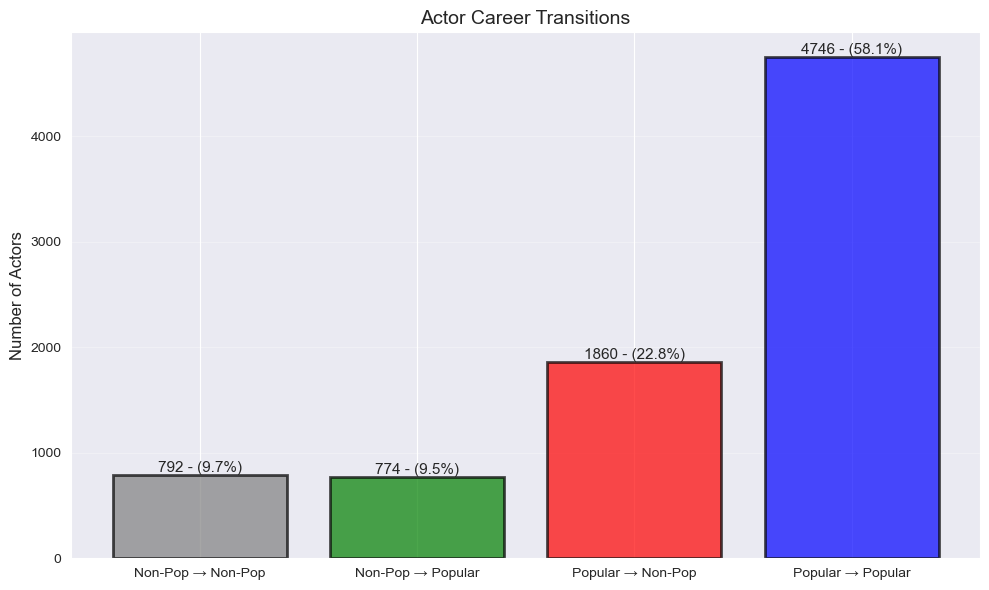

Saved: actor_career_transitions_bars.png


In [19]:
from Director_Director_Graph.director_graph_functions import actor_transitions_on_plotbar

actor_transitions_on_plotbar(transitions, total_actors, actor_min_films)

Here we make an analysis about the actors' transitions between popular and non-popular directors.

In [20]:
print("Analysis about actor Career Transitions")

started_nonpopular = transitions[('Non-Popular', 'Non-Popular')] + transitions[('Non-Popular', 'Popular')]
started_popular = transitions[('Popular', 'Non-Popular')] + transitions[('Popular', 'Popular')]

ended_nonpopular = transitions[('Non-Popular', 'Non-Popular')] + transitions[('Popular', 'Non-Popular')]
ended_popular = transitions[('Non-Popular', 'Popular')] + transitions[('Popular', 'Popular')]

upward_mobility = transitions[('Non-Popular', 'Popular')]
downward_mobility = transitions[('Popular', 'Non-Popular')]
stable_popular = transitions[('Popular', 'Popular')]
stable_nonpopular = transitions[('Non-Popular', 'Non-Popular')]

print("About the start of the actor's carreer:")
print(f"Actors who started with non-popular directors: {started_nonpopular:5d} ({started_nonpopular/total_actors*100:5.1f}%)")
print(f"Actors who started with popular directors:     {started_popular:5d} ({started_popular/total_actors*100:5.1f}%)")

print("\nAbout the end of the actor's career:")
print(f"  Actors who ended with non-popular directors:   {ended_nonpopular:5d} ({ended_nonpopular/total_actors*100:5.1f}%)")
print(f"  Actors who ended with popular directors:       {ended_popular:5d} ({ended_popular/total_actors*100:5.1f}%)")

print("\nMobility:")
print(f"  Upward mobility (Non-Pop → Popular):           {upward_mobility:5d} ({upward_mobility/total_actors*100:5.1f}%)")
print(f"  Downward mobility (Popular → Non-Pop):         {downward_mobility:5d} ({downward_mobility/total_actors*100:5.1f}%)")
print(f"  Stable at popular level:                       {stable_popular:5d} ({stable_popular/total_actors*100:5.1f}%)")
print(f"  Stable at non-popular level:                   {stable_nonpopular:5d} ({stable_nonpopular/total_actors*100:5.1f}%)")


if started_nonpopular > 0:
    prob_move_up = upward_mobility / started_nonpopular * 100
    print(f"  P(end with popular | start with non-popular) = {prob_move_up:.1f}%")

if started_popular > 0:
    prob_move_down = downward_mobility / started_popular * 100
    prob_stay_popular = stable_popular / started_popular * 100
    print(f"  P(end with popular | start with popular)     = {prob_stay_popular:.1f}%")
    print(f"  P(end with non-popular | start with popular) = {prob_move_down:.1f}%")


print(f"\n\nNet upward mobility: {upward_mobility - downward_mobility:+d} actors")
if upward_mobility > downward_mobility:
    print(f"More actors moved up to popular directors than moved DOWN")
elif downward_mobility > upward_mobility:
    print(f"More actors moved down from popular directors than moved UP")
else:
    print(f"Equal upward and downward mobility")

print(f"\n{stable_popular + stable_nonpopular} actors ({(stable_popular + stable_nonpopular)/total_actors*100:.1f}%) stayed at the same level")
print(f"{upward_mobility + downward_mobility} actors ({(upward_mobility + downward_mobility)/total_actors*100:.1f}%) changed levels")

Analysis about actor Career Transitions
About the start of the actor's carreer:
Actors who started with non-popular directors:  1566 ( 19.2%)
Actors who started with popular directors:      6606 ( 80.8%)

About the end of the actor's career:
  Actors who ended with non-popular directors:    2652 ( 32.5%)
  Actors who ended with popular directors:        5520 ( 67.5%)

Mobility:
  Upward mobility (Non-Pop → Popular):             774 (  9.5%)
  Downward mobility (Popular → Non-Pop):          1860 ( 22.8%)
  Stable at popular level:                        4746 ( 58.1%)
  Stable at non-popular level:                     792 (  9.7%)
  P(end with popular | start with non-popular) = 49.4%
  P(end with popular | start with popular)     = 71.8%
  P(end with non-popular | start with popular) = 28.2%


Net upward mobility: -1086 actors
More actors moved down from popular directors than moved UP

5538 actors (67.8%) stayed at the same level
2634 actors (32.2%) changed levels


Analyze whether the popularity have a correlation with different metrics. (megnézni!!!!

Correlation summary: Network Metrics vs Director Popularity

EIGENVECTOR CENTRALITY:
  vs total popularity:
    Spearman r =   0.416 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Spearman r =  -0.416 (p = 0.0000)
    → Moderate correlation ***

PAGERANK:
  vs total popularity:
    Spearman r =   0.581 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Spearman r =  -0.581 (p = 0.0000)
    → Moderate correlation ***

IN DEGREE:
  vs total popularity:
    Spearman r =   0.550 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Spearman r =  -0.550 (p = 0.0000)
    → Moderate correlation ***

OUT DEGREE:
  vs total popularity:
    Spearman r =   0.551 (p = 0.0000)
    → Moderate correlation ***
  vs popularity rank:
    Spearman r =  -0.551 (p = 0.0000)
    → Moderate correlation ***


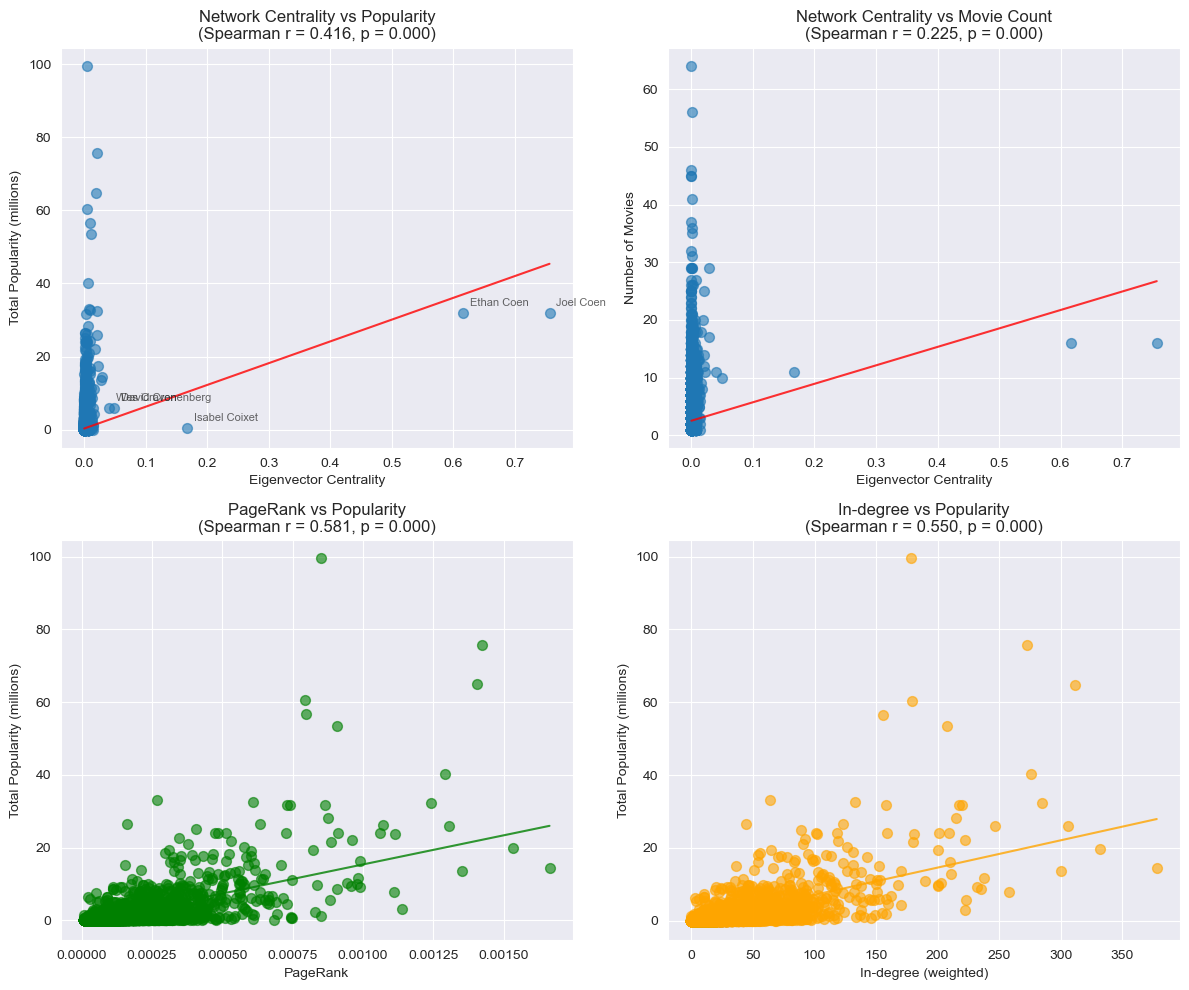

Director ranking comparison: Network Centrality vs Popularity

Rank correlation (Spearman): 0.416 (p=0.0000)
Top-5 overlap: 0.0%
Top-10 overlap: 20.0%
Top-20 overlap: 30.0%
Top 10 directors comparison
Director                       Network Rank    Popularity Rank      Total Popularity    
-------------------------------------------------------------------------------------
Joel Coen                      1               12                             31,810,722
Ethan Coen                     2               11                             31,810,722
Isabel Coixet                  3               1138                              569,534
David Cronenberg               4               203                             5,987,757
Wes Craven                     5               199                             6,049,004
Woody Allen                    6               58                             14,421,317
Robert Rodriguez               7               62                             13,629,570
S

In [40]:
from director_graph_functions import analyze_director_prestige
results, merged_df, comparison = analyze_director_prestige(director_graph, director_popularity)


# Network Distance to Top 10 Directors vs Popularity

Analyze whether the shortest path distance from a director to one of the top 10 most popular directors is linked to their own popularity.

In [42]:
from Director_Director_Graph.director_graph_functions import analyze_distance_to_top_directors

# Run the analysis with DIRECTED distances
results_df, corr, p_value = analyze_distance_to_top_directors(
    director_graph, 
    director_popularity, 
    top_n=10
)

Top 10 most popular directors:
   1. Christopher Nolan (popularity: 99,486,882)
   2. Quentin Tarantino (popularity: 75,651,625)
   3. Steven Spielberg (popularity: 64,856,946)
   4. Peter Jackson (popularity: 60,483,110)
   5. David Fincher (popularity: 56,634,055)
   6. Martin Scorsese (popularity: 53,531,790)
   7. Ridley Scott (popularity: 40,214,401)
   8. Frank Darabont (popularity: 33,075,602)
   9. Robert Zemeckis (popularity: 32,672,930)
  10. Clint Eastwood (popularity: 32,379,841)

Top directors found in graph: 10/10
(Measures: how many career steps to reach a top director)

Reachability from directors to top 10:
  Can reach top 10: 16,510 directors
  Cannot reach top 10: 597 directors (no directed path exists)
Distance to Top 10 vs Popularity

Sample size: 14951 directors (excluding top 10)

Distance to nearest top 10 director vs Total Popularity:
  Spearman r = -0.3384 (p = 0.0000e+00)

=> Strong negative correlation (highly significant (p < 0.001))
   Directors with short

# Director Transition Probabilities

Define $P[i_{t+1} | i_t]$ as the probability that an actor, currently working with director $i_t$, next makes a film with director $i_{t+1}$.

This is calculated as:
$$P[i_{t+1} | i_t] = \frac{w(i_t \to i_{t+1})}{\sum_{j} w(i_t \to j)}$$

where $w(i_t \to i_{t+1})$ is the number of actors who transitioned from director $i_t$ to director $i_{t+1}$.

In [26]:
from director_graph_functions import compute_transition_probabilities

transition_probs, out_degree_weights = compute_transition_probabilities(director_graph)


In [27]:
top_n = 10

In [28]:
from director_graph_functions import calculate_group_transition_probability
group_results = calculate_group_transition_probability(director_popularity, director_graph, transition_probs, top_n)

print(f"\n{'Popularity Tier':<15} {'N Directors':<15} {'Avg P[top10 | tier]':<20}")
for row in group_results:
    print(f"{row['group']:<15} {row['n_directors']:<15} {row['avg_prob_to_top10']:.6f}")


Popularity Tier N Directors     Avg P[top10 | tier] 
Top 100         91              0.020615
Top 500         396             0.020296
Top 1000        485             0.014047
Top 5000        3405            0.010064
Rest            10970           0.007741


## Network-Constrained Transition Model

**Our Assumption**: An actor working with director $i_t$ can only transition to directors $i_{t+1}$ who have previously worked with actors from director $i_t$. This creates a network effect where reachable directors are determined by past actor movements.

In this model:
- $\mathcal{N}(i_t)$ = set of directors reachable from $i_t$ (neighbors in the graph)
- $P[i_{t+1} | i_t] > 0$ only if $i_{t+1} \in \mathcal{N}(i_t)$

This means directors who are not connected to popular directors through the actor-movement network have **zero probability** of receiving actors from those popular directors, creating potential "gatekeeping" effects.

In [29]:
from director_graph_functions import analyze_network_accessibility
accessibility_results = analyze_network_accessibility(director_graph, director_popularity, top_n)


1. Directors who can receive actors from top 10:
   1,357 directors (7.9% of network)

2. Directors who can send actors to top 10:
   1,293 directors (7.6% of network)

3. Directors with bidirectional access to top 10:
   458 directors (2.7% of network)

4. Directors with no direct connection to top 10:
   14,915 directors (87.1% of network)
Popularity comparison of Accessible vs Non-Accessible Directors

Metric                         Connected to Top 10       Not Connected            
Count                          2,134                     13,213                   
Mean Popularity                1,504,952                 98,950                   
Median Popularity              99,071                    6,335                    
Max Popularity                 31,810,722                24,117,234               

Mann-Whitney U test (accessible > non-accessible):
  U-statistic: 21,481,584
  P-value: 0.0000e+00
  => Highly significant: Directors connected to top 10 are more popular


## Random Walk Model of Actor Careers

Model an actor's career as a **random walk** on the director network:

- At each step $t$, the actor is working with director $i_t$
- The probability of transitioning to director $i_{t+1}$ is:

$$P[i_{t+1} | i_t] = \frac{w(i_t \to i_{t+1})}{\sum_{j \in \mathcal{N}(i_t)} w(i_t \to j)}$$

where $w(i_t \to i_{t+1})$ is the number of actors who previously transitioned from $i_t$ to $i_{t+1}$.

This models career paths as being influenced by historical patterns of actor movement.

In [30]:
from Director_Director_Graph.director_graph_functions import get_transition_probabilities, simulate_many_careers
transition_probs = get_transition_probabilities(director_graph)

print("Simulating 10,000 actor careers (10 steps each)...")
visit_counts, final_positions = simulate_many_careers(director_graph, n_simulations=10000, n_steps=10, transition_probs=transition_probs)

print(f"\nDirectors visited at least once: {len(visit_counts):,}")
print(f"Unique final positions: {len(final_positions):,}")


Simulating 10,000 actor careers (10 steps each)...

Directors visited at least once: 15,380
Unique final positions: 5,345


Random walk results and popularity


Top 20 most visited directors (random walk simulation):
Rank   Director                            Visits     Actual Popularity   
1      Woody Allen                         201                14,421,317
2      Steven Soderbergh                   175                19,772,947
3      Clint Eastwood                      174                32,379,841
4      Quentin Tarantino                   172                75,651,625
5      Steven Spielberg                    164                64,856,946
6      Ridley Scott                        162                40,214,401
7      Michael Bay                         159                25,928,065
8      Robert Rodriguez                    156                13,629,570
9      Spike Lee                           146                 7,802,419
10     Steven Brill                        143                 3,057,472
11     Kevin Smith                         134                 9,551,290
12     Ron Howard                          133                26,

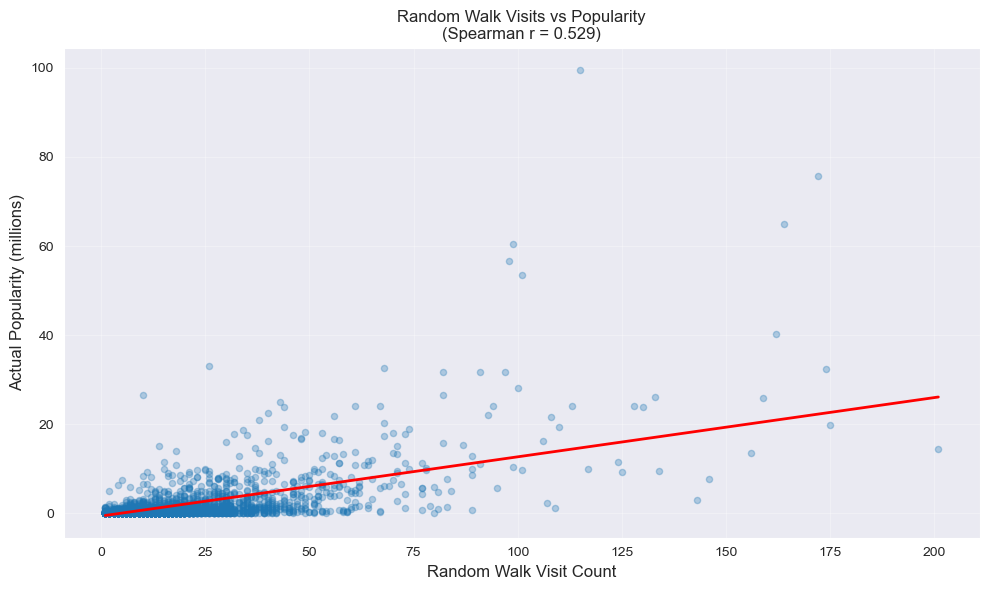


Top-20 overlap: 7/20 directors appear in both random walk and popularity top-20


In [45]:
from Director_Director_Graph.director_graph_functions import top_20_most_visited_directors_and_total_popularity, \
    visualize_top_20_most_visited_directors_and_total_popularity

merged, spearman_r, pearson_r= top_20_most_visited_directors_and_total_popularity(visit_counts, director_popularity )

visualize_top_20_most_visited_directors_and_total_popularity(merged,spearman_r,visit_counts, director_popularity)

## Memory-Based Transition Model (Equation 1)

Extend the random walk model to include a **memory component** that considers the actor's full filmography $(i_1, i_2, \ldots, i_t)$:

$$P[i_{t+1} | i_t, \ldots, i_1] = K \cdot \mu[\pi_{i_{t+1}}; m_\tau] \cdot P[i_{t+1} | i_t] \tag{1}$$

**Memory function:**
$$\mu[\pi_{i_{t+1}}; m_\tau] = \frac{P[\pi_{i_{t+1}} | m_\tau]}{P[\pi_{i_{t+1}}]} \tag{2}$$

**Average reputation:**
$$m_\tau = \frac{1}{\tau} \sum_{k=1}^{n_\tau} \pi_{i_{\tau-k+1}} \tag{3}$$

Where:
- $m_\tau$ = average prestige of the actor's past $n_\tau$ exhibitions/films
- $P[\pi_{i_{t+1}} | m_\tau]$ = probability of next director's prestige given actor's memory
- $P[\pi_{i_{t+1}}]$ = marginal probability of that prestige level
- $K$ = normalization constant

In [32]:
from Director_Director_Graph.director_graph_functions import estimate_Pn, get_bin, calculate_transitions_with_memory_context, get_P_pi_given_m, estimate_pim
import numpy as np

# Create director prestige dictionary (using log-popularity for numerical stability)
director_prestige = {}
for _, row in director_popularity.iterrows():
    director_prestige[row['director']] = np.log1p(row['total_popularity'])

# Get min/max for normalization
prestige_values = list(director_prestige.values())
prestige_min, prestige_max = min(prestige_values), max(prestige_values)

print("Estimate P[π] and P[π|m] from actual actor career data...")

# Discretize prestige into bins for probability estimation
n_bins = 20
prestige_bins = np.linspace(0, 1, n_bins + 1)

# Collect all transitions with memory context from actual data
transitions_data, all_prestiges = calculate_transitions_with_memory_context(actor_directors_dict, director_prestige, prestige_min, prestige_max)


# Estimate P[π] - marginal probability of prestige
P_pi = estimate_Pn(n_bins, all_prestiges, prestige_bins)

# Estimate P[π|m] - conditional probability given memory
# Create 2D histogram: rows = m_tau bins, cols = pi_next bins
joint_counts, m_tau_counts = estimate_pim(n_bins, transitions_data, prestige_bins)

# P[π|m] = joint / P[m]
P_pi_given_m = get_P_pi_given_m(n_bins, m_tau_counts, joint_counts)

print(f"Probability distributions estimated over {n_bins} bins")




Estimate P[π] and P[π|m] from actual actor career data...
Probability distributions estimated over 20 bins


Here we simulate 5000 actors in the graph.

In [58]:
from Director_Director_Graph.director_graph_functions import memory_random_walk_eq1, simulating_careers
import random

# Simulate careers with memory model
print("Simulating 5,000 careers with MEMORY model (Eq. 1, n_τ=5)...")
np.random.seed(42)
random.seed(42)

starting_directors = [d for d in director_graph.nodes() if director_graph.out_degree(d) > 0]
memory_visits, memory_careers, visit_df = simulating_careers(director_graph, director_popularity, prestige_min, prestige_max,prestige_bins, P_pi_given_m, P_pi,director_prestige,n_steps=10,n_tau=5, transition_probs=transition_probs)

print(f"Simulated {len(memory_careers):,} careers")
print(f"Directors visited: {len(memory_visits):,}")
print(f"The most visited directors are popular directors:")
visit_df

Simulating 5,000 careers with MEMORY model (Eq. 1, n_τ=5)...
Simulated 5,000 careers
Directors visited: 13,356
The most visited directors are popular directors:


,director,visit_count,popularity_rank
0,Steven Soderbergh,81,33.0
1,Woody Allen,75,58.0
2,Ridley Scott,74,7.0
3,Ethan Coen,72,11.0
4,Quentin Tarantino,69,2.0
...,...,...,...
13351,Ajit Sinha,1,NaN
13352,Chris Munro,1,20266.0
13353,Noelle Benvenuti,1,5553.0
13354,Nathalie Biancheri,1,23317.0


HYPOTHESIS TEST: Reputation → Prestige Transition

H1: Actors with LOW reputation (m≈0.1) have higher chance of moving to LOW-prestige directors
H2: Actors with HIGH reputation (m≈0.9) have higher chance of staying at HIGH-prestige venues
Probability of transitioning to LOW-prestige directors (π < 0.3)
  P[low-popularity | m = 0.1 (low popularity)]  = 0.2959
  P[low-popularity | m = 0.9 (high popularity)] = 0.0569
  P[low-popularity] (marginal)                  = 0.1663

  Ratio: Low-popularity actors are 5.20x more likely
         to move to low-popularity directors than high-popularity actors
H1 is true: Low-popularity actors more likely to work with low-popularity directors
Probability of transitioning to HIGH-popularity directors (π > 0.7)
  P[high-popularity | m = 0.9 (high popularity)] = 0.5166
  P[high-popularity | m = 0.1 (low popularity)]  = 0.1456
  P[high-popularity] (marginal)                  = 0.2730

  Ratio: High-popularity actors are 3.55x more likely
         to work 

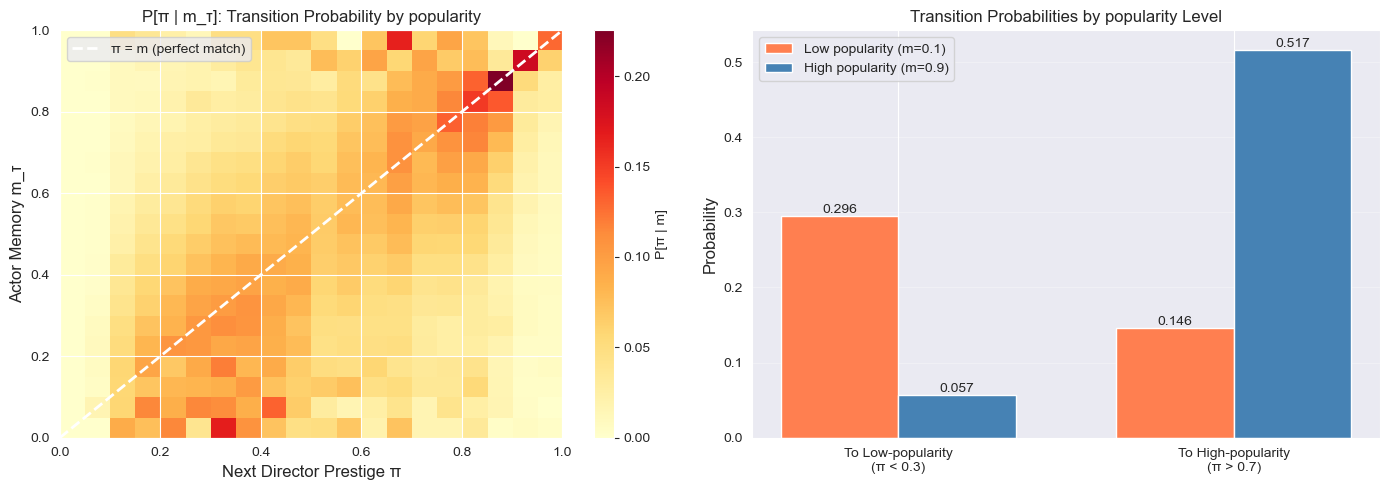

In [63]:
from Director_Director_Graph.director_graph_functions import testing_hypothesis

testing_hypothesis(prestige_bins, P_pi_given_m, P_pi)

## Actor Quality Analysis: Are Actors Working with Popular Directors Actually Good Actors?

Using the Celebrity.csv dataset which ranks actors by popularity, we analyze whether actors who work with popular directors are themselves highly-ranked actors.

In [62]:
from Director_Director_Graph.director_graph_functions import get_actors_to_popular_directors

# Load Celebrity dataset with actor popularity rankings
df_celebrity = pd.read_csv('../Datasets/Celebrity.csv', index_col=0)

# Create a mapping of actor name to popularity
actor_popularity_map = dict(zip(df_celebrity['name'], df_celebrity['popularity']))

# For each actor in our dataset, check if they worked with popular directors
actors_with_popular, actors_without_popular = get_actors_to_popular_directors(actor_directors_dict, popular_directors)


print(f"Actor Distribution:")
print(f"  Actors who worked with popular directors:     {len(actors_with_popular):5d}")
print(f"  Actors who never worked with popular directors: {len(actors_without_popular):5d}")
print(f"  Total actors: {len(actor_directors_dict):5d}")

Actor Distribution:
  Actors who worked with popular directors:      8838
  Actors who never worked with popular directors:   296
  Total actors:  9134


Analyze the career trajectories of popular actors: which directors did they work with and in what sequence? What is the mean percentage of popular directors that popular actors work with.

In [80]:
# Get top 50 popular actors from Celebrity dataset
top_n_actors = 500
top_popular_actors = []
for _, row in df_celebrity.iterrows():
    actor_name = row['name']
    if actor_name in actor_directors_dict:
        top_popular_actors.append((actor_name, row['popularity']))
    if len(top_popular_actors) >= top_n_actors:
        break

print(f"Analyzing director paths for top {len(top_popular_actors)} popular actors\n")

# Analyze their director paths
actor_paths = {}

for actor_name, actor_pop in top_popular_actors:
    directors_list = actor_directors_dict[actor_name]
    
    # Create path: sequence of (director, is_popular, year)
    path = []
    for d in directors_list:
        is_popular = d['director'] in popular_directors
        path.append({'director': d['director'],'is_popular': is_popular})
    
    actor_paths[actor_name] = {
        'path': path,
        'popularity': actor_pop,
        'num_films': len(path),
        'num_popular_directors': sum(1 for p in path if p['is_popular']),
        'percent_popular': sum(1 for p in path if p['is_popular']) / len(path) * 100 if len(path) > 0 else 0
    }

average_percent_popular = sum(data['percent_popular'] for data in actor_paths.values()) / len(actor_paths)
print(f"The mean percentage of popular directors that the top {top_n_actors} popular actors work with.: {average_percent_popular:.2f}%")

# Print summary for first 10 actors
print("\nPopular actors: director path")

for i, (actor, data) in enumerate(list(actor_paths.items())[:10], 1):
    print(f"\n{i:2d}. {actor} (popularity: {data['popularity']:.1f})")
    print(f"    Films: {data['num_films']}")
    print(f"    Worked with popular directors: {data['num_popular_directors']}/{data['num_films']} ({data['percent_popular']:.1f}%)")
    print(f"    Career path: ", end="")
    
    # Show pattern (P = popular, N = non-popular)
    pattern = ''.join(['P' if p['is_popular'] else 'N' for p in data['path']])
    if len(pattern) > 40:
        print(f"{pattern[:40]}... ({len(pattern)} films total)")
    else:
        print(pattern)


Analyzing director paths for top 500 popular actors

The mean percentage of popular directors that the top 500 popular actors work with.: 82.61%

Popular actors: director path

 1. Gary Oldman (popularity: 212.9)
    Films: 61
    Worked with popular directors: 57/61 (93.4%)
    Career path: PPPPPPPPPPPPPPPPPPPPNPPPPPPPPNPPNPPPPPPP... (61 films total)

 2. Ryan Reynolds (popularity: 199.7)
    Films: 53
    Worked with popular directors: 46/53 (86.8%)
    Career path: NNPPNNNNPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP... (53 films total)

 3. Sydney Sweeney (popularity: 193.4)
    Films: 18
    Worked with popular directors: 6/18 (33.3%)
    Career path: PPPNNNNNNNPNNPPNNN

 4. Jason Statham (popularity: 187.8)
    Films: 45
    Worked with popular directors: 45/45 (100.0%)
    Career path: PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP... (45 films total)

 5. Chloe Coleman (popularity: 175.6)
    Films: 3
    Worked with popular directors: 3/3 (100.0%)
    Career path: PPP

 6. Scarlett Johansson (p

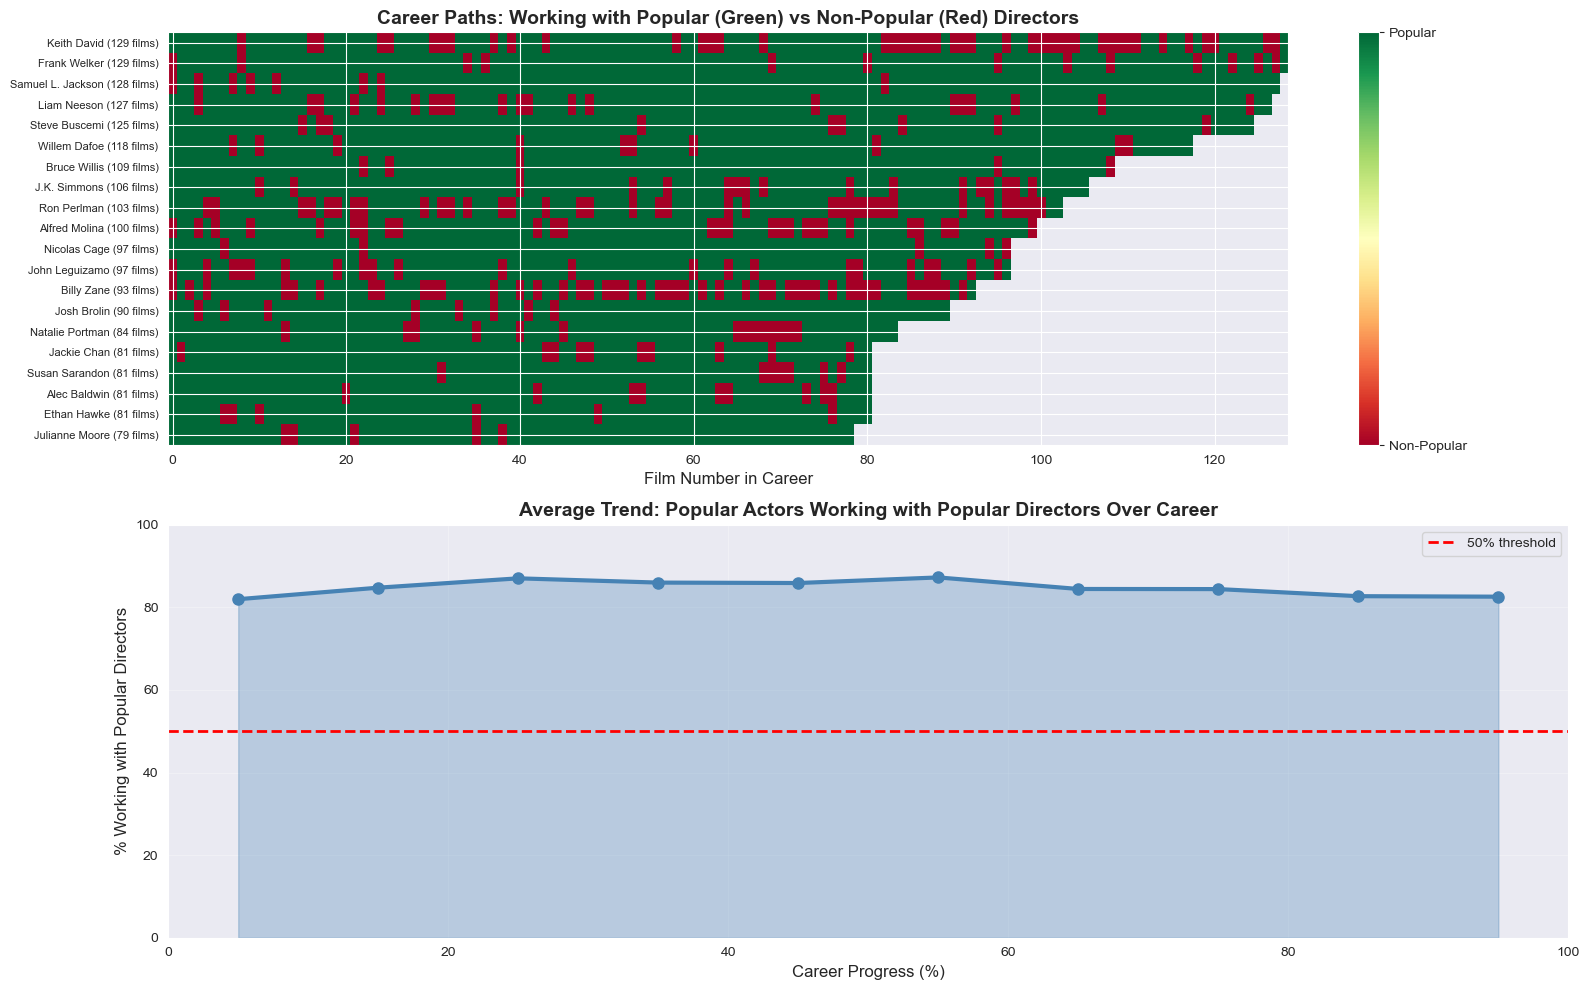


Saved: popular_actors_director_paths.png


In [79]:
from matplotlib import pyplot as plt

# Visualize career paths for top 20 popular actors
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Heatmap of director popularity over career
ax1 = axes[0]

# Select top 20 actors with longest careers for visualization
top_20_by_films = sorted(actor_paths.items(), 
                         key=lambda x: x[1]['num_films'], 
                         reverse=True)[:20]

# Create matrix: rows = actors, columns = film number
max_films = max(data['num_films'] for _, data in top_20_by_films)
matrix = np.full((len(top_20_by_films), max_films), np.nan)

actor_labels = []
for i, (actor, data) in enumerate(top_20_by_films):
    actor_labels.append(f"{actor[:20]} ({data['num_films']} films)")
    for j, step in enumerate(data['path']):
        matrix[i, j] = 1 if step['is_popular'] else 0

# Create heatmap
im = ax1.imshow(matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax1.set_yticks(range(len(actor_labels)))
ax1.set_yticklabels(actor_labels, fontsize=8)
ax1.set_xlabel('Film Number in Career', fontsize=12)
ax1.set_title('Career Paths: Working with Popular (Green) vs Non-Popular (Red) Directors', 
              fontsize=14, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Non-Popular', 'Popular'])

# Plot 2: Average % working with popular directors over career progression
ax2 = axes[1]

# Normalize careers to percentage (0-100%)
normalized_careers = []
for actor, data in actor_paths.items():
    if data['num_films'] >= 5:
        path = data['path']
        # Convert to normalized positions (0-100%)
        for i, step in enumerate(path):
            career_position = i / (len(path) - 1) * 100 if len(path) > 1 else 0
            normalized_careers.append({
                'position': career_position,
                'is_popular': 1 if step['is_popular'] else 0
            })

# Bin by career position
bins = np.linspace(0, 100, 11)  # 10 bins
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_means = []

for i in range(len(bins) - 1):
    in_bin = [c['is_popular'] for c in normalized_careers 
              if bins[i] <= c['position'] < bins[i+1]]
    if in_bin:
        bin_means.append(np.mean(in_bin) * 100)
    else:
        bin_means.append(0)

ax2.plot(bin_centers, bin_means, 'o-', linewidth=3, markersize=8, color='steelblue')
ax2.fill_between(bin_centers, bin_means, alpha=0.3, color='steelblue')
ax2.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% threshold')

ax2.set_xlabel('Career Progress (%)', fontsize=12)
ax2.set_ylabel('% Working with Popular Directors', fontsize=12)
ax2.set_title('Average Trend: Popular Actors Working with Popular Directors Over Career', 
              fontsize=14, fontweight='bold')
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('popular_actors_director_paths.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: popular_actors_director_paths.png")